### Name: Hari Vengadesh

#### Homework 3

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime

import PIL
import PIL.Image
import pathlib

from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf

from sklearn.metrics import confusion_matrix
import seaborn as sns

print(tf.__version__)

2.10.0


In [3]:
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda)
print(tf.test.gpu_device_name())
print(tf.config.get_visible_devices())

[]
<function is_built_with_cuda at 0x000001D8545C4D30>

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


#### Parameters

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
batch_size = 32
img_height = 28
img_width = 28

#### Data

In [6]:
data_dirpathname = r'E:\Data Science\ECE565 - Machine Learning\datasets\mnist\trainingSet\trainingSet'
data_dir = pathlib.Path(data_dirpathname)

class_names = os.listdir(data_dir)
num_classes = len(class_names)

## 1. 2.a) Code that will count number of classes
## 1. 2.b) Number of images in each class

In [7]:
images_per_class = {}
for class_name in class_names:
    images_per_class[class_name] = len(os.listdir(os.path.join(data_dir, class_name)))

print("Number of classes:", num_classes)
print("Number of images in each class:", images_per_class)

Number of classes: 10
Number of images in each class: {'0': 4132, '1': 4684, '2': 4177, '3': 4351, '4': 4072, '5': 3795, '6': 4137, '7': 4401, '8': 4063, '9': 4188}


In [8]:
image_count =  len(list(data_dir.glob('*/*.jpg')))
print('Image count:', image_count)

Image count: 42000


In [9]:
one = list(data_dir.glob('1/*'))
PIL.Image.open(str(one[0]))

In [10]:
sample_image = PIL.Image.open(str(one[1]))
img = np.asarray(sample_image)
img.shape

(28, 28)

#### Setup Dataset Pipeline

In [11]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
list_ds

<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [12]:
for f in list_ds.take(5):
    print(f.numpy())

b'E:\\Data Science\\ECE565 - Machine Learning\\datasets\\mnist\\trainingSet\\trainingSet\\1\\img_21024.jpg'
b'E:\\Data Science\\ECE565 - Machine Learning\\datasets\\mnist\\trainingSet\\trainingSet\\3\\img_25032.jpg'
b'E:\\Data Science\\ECE565 - Machine Learning\\datasets\\mnist\\trainingSet\\trainingSet\\4\\img_32604.jpg'
b'E:\\Data Science\\ECE565 - Machine Learning\\datasets\\mnist\\trainingSet\\trainingSet\\2\\img_7024.jpg'
b'E:\\Data Science\\ECE565 - Machine Learning\\datasets\\mnist\\trainingSet\\trainingSet\\2\\img_22214.jpg'


## 1. 1. Data must be split in train/test and validation set

In [13]:
test_size = int(image_count*0.2)
train_ds = list_ds.skip(test_size)
val_ds = list_ds.take(test_size)

In [14]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

33600
8400


#### Helper Functions

In [15]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [16]:
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

In [17]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [18]:
# Set 'num_parallel_calls' so multiple images are loaded/processed in parallel.

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

## 1. 2.c) Image resized to 101x101xNo_Of_channels.

## 1. 2.d) Automatic data label extraction based on sub-directory name.

## 1. 2.e) Display one batch of image/label using the dataset api.

In [19]:
for image, label in train_ds.take(1):
    print("Image shape:", image.numpy().shape)
    print("Label:", class_names[label.numpy()])

Image shape: (28, 28, 3)
Label: 3


In [20]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size=64)
    return ds

In [21]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

#### Test Dataset Pipeline

In [22]:
image_batch, label_batch = next(iter(train_ds))

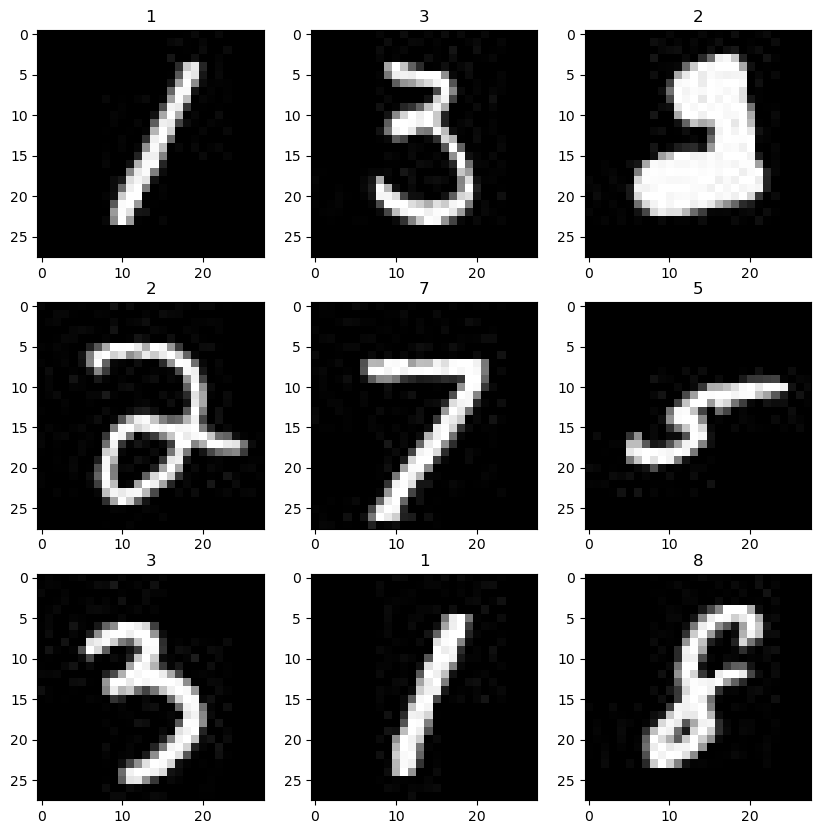

In [23]:
plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])

## 2. Model

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3), name='Input_Shape_Layer'),
    tf.keras.layers.Rescaling(1./255),  # Normalize pixel values
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

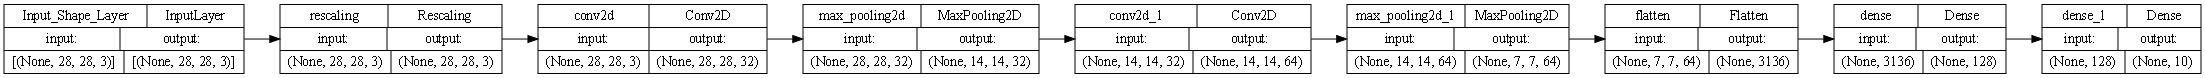

In [25]:
tf.keras.utils.plot_model(model=model, rankdir="LR", dpi=72, show_shapes=True)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### Training / Validation Cycle

In [27]:
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

## 3. Train/Validation

## 3. 1. Early stopping

In [28]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5)

In [29]:
model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=101,
    callbacks=[tensorboard_callback, early_stopping_callback],
    verbose=1
)

Epoch 1/101
525/525 [==============================] - 35s 65ms/step - loss: 0.1909 - accuracy: 0.9410 - val_loss: 0.0627 - val_accuracy: 0.9804
Epoch 2/101
525/525 [==============================] - 7s 13ms/step - loss: 0.0528 - accuracy: 0.9829 - val_loss: 0.0517 - val_accuracy: 0.9857
Epoch 3/101
525/525 [==============================] - 7s 13ms/step - loss: 0.0371 - accuracy: 0.9881 - val_loss: 0.0441 - val_accuracy: 0.9874
Epoch 4/101
525/525 [==============================] - 7s 13ms/step - loss: 0.0259 - accuracy: 0.9924 - val_loss: 0.0399 - val_accuracy: 0.9886
Epoch 5/101
525/525 [==============================] - 7s 13ms/step - loss: 0.0184 - accuracy: 0.9942 - val_loss: 0.0412 - val_accuracy: 0.9892
Epoch 6/101
525/525 [==============================] - 7s 14ms/step - loss: 0.0163 - accuracy: 0.9946 - val_loss: 0.0528 - val_accuracy: 0.9858
Epoch 7/101
525/525 [==============================] - 7s 13ms/step - loss: 0.0103 - accuracy: 0.9965 - val_loss: 0.0561 - val_accuracy

#### Evaluate Trained Model

## 4. Model Evaluation

## 4. 2. Accuracy Metrics

In [30]:
test_loss, test_acc = model.evaluate(val_ds, verbose=2)
print('\nTest Accuracy:', test_acc)

132/132 - 1s - loss: 0.0579 - accuracy: 0.9868 - 669ms/epoch - 5ms/step

Test Accuracy: 0.9867857098579407


In [31]:
all_predictions = []
all_labels = []

## 4. 1. Confusion Matrix

In [32]:
for images, labels in val_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = labels.numpy()

    all_predictions.extend(predicted_classes)
    all_labels.extend(true_classes)

1/1 [==============================] - 0s 130ms/step


In [33]:
cm = confusion_matrix(all_labels, all_predictions)
class_names_array = np.array(class_names)

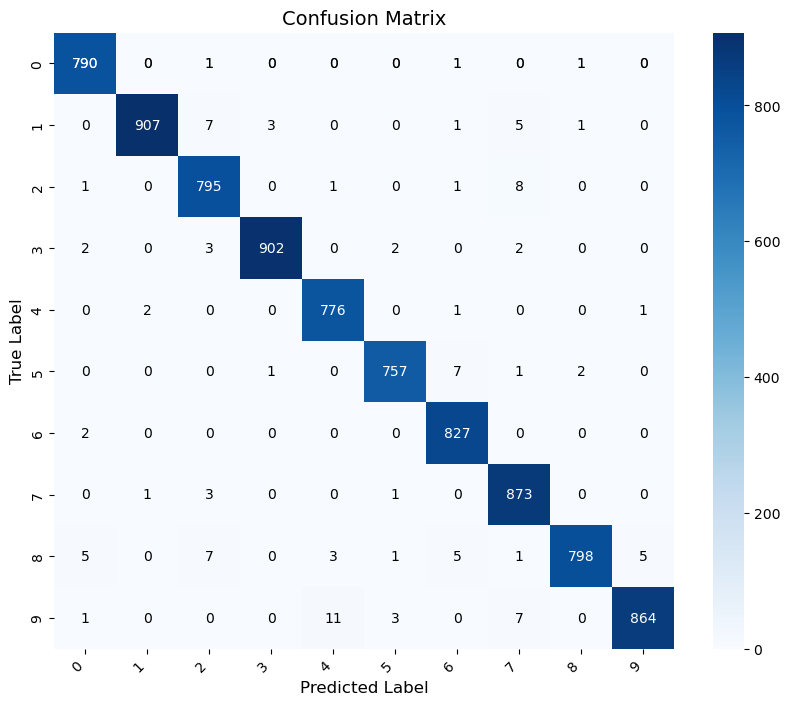

In [34]:
plt.figure(figsize=(10, 8))  # Increase figure size to make room for labels
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=class_names, yticklabels=class_names)

# Set tick labels appearance
plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjust font size or rotation as needed
plt.yticks(fontsize=10)

# Colorbar label and title
plt.title('Confusion Matrix', fontsize=14)  # Increase title font size
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Loop over data dimensions and create text annotations with contrasting colors
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black')

plt.show()

#### Make Predictions

In [35]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [36]:
predictions = probability_model.predict(val_ds)

132/132 [==============================] - 1s 7ms/step


In [37]:
predictions[0]

array([0.08533755, 0.08533755, 0.08533755, 0.08534262, 0.08533755,
       0.2319567 , 0.08533785, 0.08533755, 0.08533763, 0.08533755],
      dtype=float32)

In [38]:
class_names[np.argmax(predictions[0])]

'5'

In [39]:
image_batch, label_batch = next(iter(val_ds))

In [40]:
label_batch

<tf.Tensor: shape=(64,), dtype=int64, numpy=
array([9, 6, 9, 6, 3, 8, 0, 2, 4, 3, 9, 8, 0, 0, 4, 3, 1, 1, 2, 7, 2, 5,
       7, 9, 0, 3, 7, 7, 4, 5, 8, 5, 7, 6, 5, 6, 3, 3, 3, 9, 8, 5, 5, 9,
       3, 1, 1, 9, 7, 5, 9, 7, 5, 2, 4, 7, 4, 3, 2, 4, 7, 2, 8, 8],
      dtype=int64)>

In [41]:
predictions = probability_model.predict(image_batch)

2/2 [==============================] - 0s 4ms/step


In [42]:
np.argmax(predictions, axis=1)

array([9, 6, 9, 6, 3, 8, 0, 2, 4, 3, 9, 8, 0, 0, 4, 3, 1, 1, 2, 7, 2, 5,
       7, 9, 0, 3, 7, 7, 4, 5, 8, 5, 7, 6, 5, 6, 3, 3, 3, 9, 8, 5, 5, 9,
       3, 1, 1, 9, 7, 5, 9, 7, 5, 2, 4, 7, 4, 3, 2, 4, 7, 2, 8, 4],
      dtype=int64)

In [43]:
image_batch[0].shape

TensorShape([28, 28, 3])

In [44]:
predictions_prob = probability_model.predict(image_batch)
predictions = np.argmax(predictions_prob, axis=1)

2/2 [==============================] - 0s 15ms/step


## 5. Model Predictions

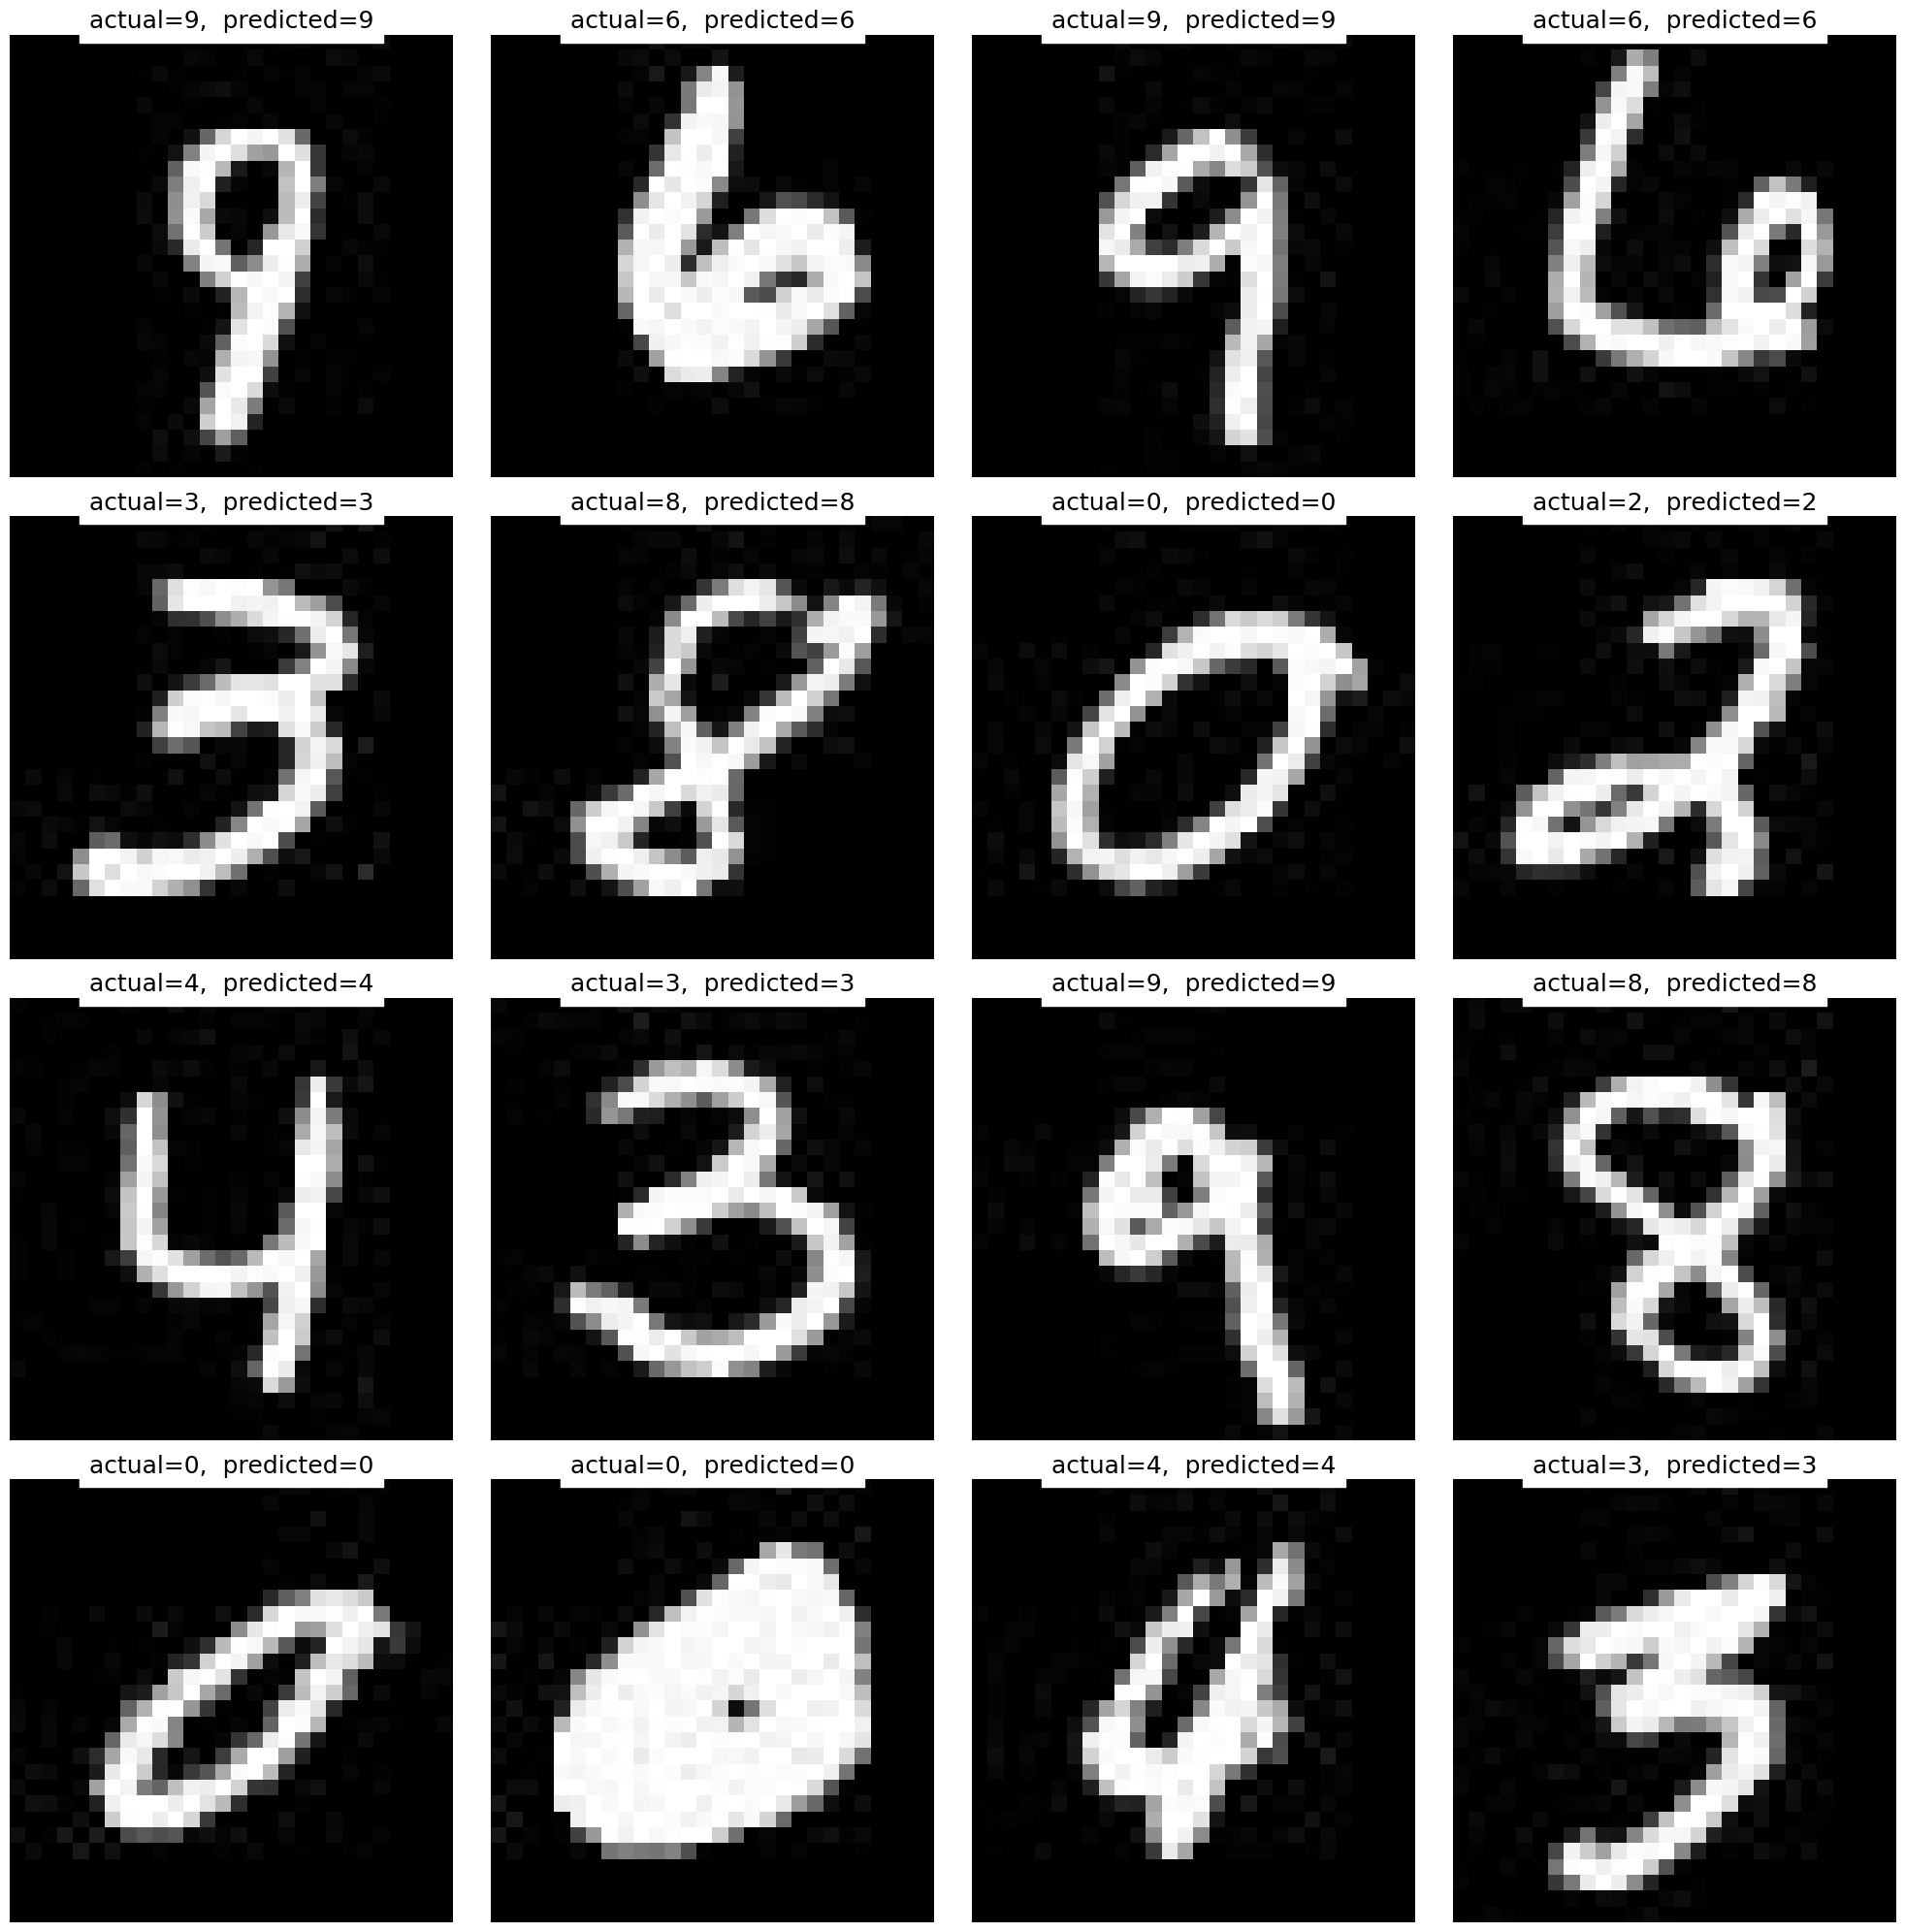

In [45]:
plt.figure(figsize=(20, 20))
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.titlepad'] = 5

for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    true_label = class_names[label_batch[i]]
    predicted_label = class_names[predictions[i]]
    title_text = f'actual={true_label},  predicted={predicted_label}'
    plt.title(title_text, wrap=True, backgroundcolor='white', fontsize=18) 
    plt.axis('off')

plt.tight_layout(pad=1.0)
plt.show()

## 3. 2. Tensorboard

In [46]:
%load_ext tensorboard
%tensorboard --logdir {logdir}